## Extreme Value Statistics in strongly clustered environments

This notebook serves to demonstrate how to use the code for the paper by Jespersen, Carnall, and Lovell, 2025

```Explaining ultra-massive quiescent galaxies at $3 < z < 5$ in the context of their environments```

Aimed to provide a way to analyze the expected mass of extreme galaxies, **if** we have some sense of their **environments**. The method builds on the Extreme Value Statistics (EVS) method applied to stellar/halo mass functions, especially the implementation introduced by [Lovell et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518.2511L/abstract). Our method adds environment by considering the clustering of galaxies through what is usually known as _cosmic variance_, which quantifies the field-to-field variation in the stellar mass function (SMF) due to variations in the background density of the universe, meaning that it is a physical, not just statistical, variance.

Because the SMF varies with background density, we can split the SMF for a given survey up by the _density percentile_ of subvolumes in that survey, with the variance between subvolumes set primarily by the cosmic variance.
Our code then exploits that we can reasonably estimate exactly which _density percentile_ a given extreme galaxy inhabits, if we are willing to assume that it is in the most dense environment in a given survey. We can then compute a distribution over most extreme density percentiles using normal EVS, and then convolve it with the EVS estimates for the most massive galaxy in the subvolumes of a full survey volume. 

What this tends to give you is slighty higher (0.3-1.0 dex, depending on the survey and overdensity) expectation values for the mass of the most massive galaxy in a given survey. This is a statistical reflection of some good old physical intuition:

#### "You should be less surprised to find an extremely massive galaxy if you already knew that it was sitting in the center of a very dense cluster"

Anyway, let's get to using it!!

In [1]:
# !pip install -r requirements.txt

In [2]:
## first, we'll import the wrapper function so that we can actually run the function
from evs_clustering_fast_new import run_evs_clustering

To run the code, we need to specify three blocks of parameters:
- The dimensions of the survey
- The dimensions of the overdensity that our extreme galaxy inhabits
- Parameters to specify how the calculation should be run

Let's do an example for the ```EXCELS``` survey with one of the overdensities we identified

In [3]:
# Survey geometry parameters
survey_params = {
    'z_min': 3.0,                    # Minimum redshift of the survey volume where the galaxy could have been found
    'z_max': 5.0,                    # Maximum redshift of the survey volume where the galaxy could have been found
    'dRA_survey': 1402 / 3600,       # Survey RA width in degrees
    'dDEC_survey': 844.6 / 3600      # Survey DEC height in degrees
}

# Overdensity parameters
od_params = {
    'z_r': 0.0056,                     # Redshift radius of overdensity
    'z_OD': 4.622,                    # Central redshift of overdensity
    'dDEC_OD': 6 / 3600,           # Declination radius in degrees (converted from arcsec)
    'dRA_OD': 130.6 / 3600,            # RA radius in degrees (converted from arcsec)
    'Ntrials': int(2e7),             # Number of percentiles to compute in the ]0;1[ interval, if unspecified, it will be estimated
    'geometry': 'ellipsoid'          # Geometry of overdensity region, possibilities are "ellipsoid", "cylinder", "rectangle"
}

# General parameters for the run
run_params = {
    'name': 'EXCELS_highz',              # Output name
    'recalculate_cv': False,          # Recompute the cosmic variance, if this is the first time that you're running the code, set as True
    'n_z': 10                        # Number of redshift points to run the calculation at, we'll do 10 for demonstration purposes
}

The ```'recalculate_cv'``` keyword is quite important for the runtime, since it's the calculation of the cosmic variance that takes by far the longest. If you've already run the code once for a given overdensity (so that you have the cosmic variance parameter table), it speeds up the code by a factor of 100-200 to not recalculate the cosmic variance.

But since this is the first time that we're running it, we will have to spend a while waiting for the computer to do a some complicated numerical integrals.

In [4]:
output_dict = run_evs_clustering(survey_params, od_params, run_params)

The physical volume of the overdensity is 0.09 pMpc³, in comoving units it is 15.29 Mpc³, and the total physical survey volume is 33716.59 pMpc³, in comoving units it is 2157861.57 Mpc³.
The total number of possible subvolumes is: 391796.71, corresponding to a typical outlier degree of 4.56 sigma in gaussian units.
Calculating at the following redshifts
[ 2.86   3.326  3.879  4.541  5.344  6.334  7.571  9.148 11.203 13.949
 17.738]


100%|███████████████████████████████████████████████████████████████| 11/11 [00:21<00:00,  1.99s/it]


Results saved to data/EXCELS_highz_OD_4.622_addsig_0.h5


## Now let's plot it

In [14]:
def plotax(ax, zs, meds, sig1s, sig2s, sig3s = None, xlabel = True, d=0, ylabel = True, c='orange', survey = 'GS-55410 ', ty = 'SED-fitting', filter_size = 0.1, xmin = 3.2, log = False, leg = False, met = '', med_label = False):
    if log:
        meds, sig1s, sig2s = np.log10( meds ), np.log10( sig1s ), np.log10( sig2s )
    if c == 'b' or c == 'royalblue':
        med_color = 'darkblue'
    elif c == 'red':
        med_color = 'darkred'
    elif c =='grey':
        med_color = 'darkslategrey' 
    else:
        med_color = 'k'
    if med_label:
        ax.plot(zs, np.array(meds)-d, c = med_color, linestyle = 'dashed', linewidth=4, label = r'$\mathrm{Median}$', zorder = 10)
    else:
        ax.plot(zs, np.array(meds)-d, c = med_color, linestyle = 'dashed', linewidth=4, zorder = 10)
        
    ax.fill_between(zs, gaussian_filter1d(np.vstack(sig1s)[:,0], filter_size)-d,\
                          gaussian_filter1d(np.vstack(sig1s)[:,1], filter_size)-d, color = c, rasterized = True,\
                        alpha=0.3, label = r'1$\sigma$'+met)
    
    ax.fill_between(zs, gaussian_filter1d(np.vstack(sig2s)[:,0], filter_size)-d,\
                          gaussian_filter1d(np.vstack(sig2s)[:,1], filter_size)-d, color = c, rasterized = True,\
                        alpha=0.2, label = r'2$\sigma$'+met)
    if np.any(sig3s):
        ax.fill_between(zs, gaussian_filter1d(np.vstack(sig3s)[:,0], filter_size)-d,\
                          gaussian_filter1d(np.vstack(sig3s)[:,1], filter_size)-d, color = c, rasterized = True,\
                        alpha=0.1, label = r'3$\sigma$'+met)
    
    ax.grid(visible = True,alpha=0.3)
    if ty:
        ax.set(title = f'{survey}{ty}', ylim = (9,11.65), xlim = (xmin,12.4))
    else:
        ax.set(ylim = (8,11.8), xlim = (3.2,12.4))
        
    if ylabel:
        # ax.set(ylabel = r'$\mathrm{Stellar~mass}$ [$\mathrm{log}(M_*/M_{\odot})$]')
        ax.set(ylabel = r'$\mathrm{M_{*,max}}$ [$\mathrm{log}(M_*/M_{\odot})$]')

    if xlabel:
        ax.set(xlabel=r'$\mathrm{z}$')

    if leg:
        ax.legend(ncol=2, fontsize = 16, loc = 'lower left', columnspacing=0.5)

    return ax

def compute_conf_intervals(pdf, x, lims = [0.0013498980, 0.0227501319, 0.15865525, 
                                      0.500, 0.8413447, 0.97724986, 0.998650102]):
    """
    Compute confidence intervals for a given pdf
    
    Parameters
    ----------
    x (array): x coordinates
    pdf (array): probability density function evaluated at x
    lims (array): confidence intervals to compute

    Returns
    -------
    CI (array): confidence intervals
    
    """
    
    from scipy import integrate
    norm = integrate.trapz(pdf, x)
    intcum = integrate.cumtrapz(pdf/norm.reshape(-1,1), x, initial=0.)
    if np.squeeze(pdf).ndim > 1:
        CI = []
        for ic in intcum:
            CIz = []
            for lim in lims:
                CIz.append(x[np.argmin(np.abs(ic-lim))])
            CI.append(CIz)
    else:
        CI = x[[np.max(np.where(intcum < lim)) for lim in lims]]
        
    return intcum, np.vstack(CI)


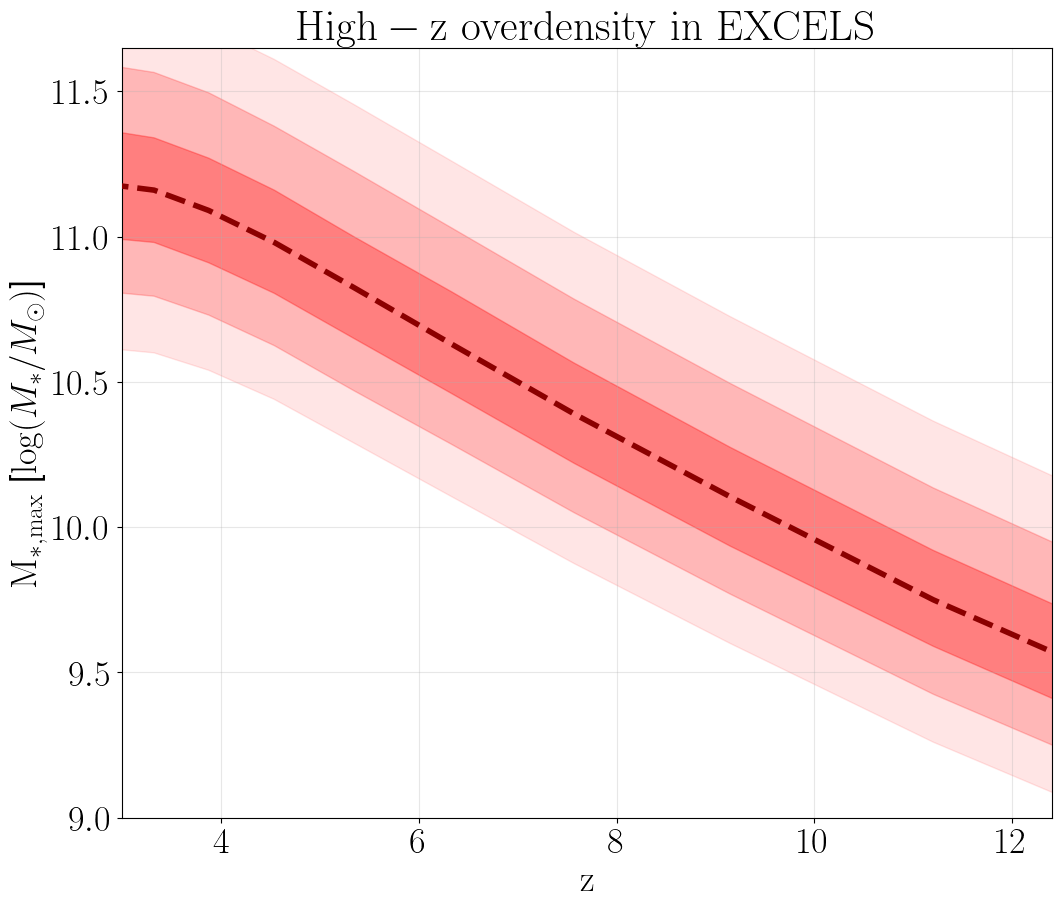

In [23]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy.ndimage import gaussian_filter1d

plt.rc('text', usetex=True)
import matplotlib as mpl
font = {'size'   : 26}
mpl.rc('font', **font)
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 10))

c = 'red'

lw1 = 4
alpha1 = 0.8
d = 0.0
title = r'$\mathrm{High-z~overdensity~in~EXCELS}$'

with h5py.File(f'../evstats/data/EXCELS_highz_OD_4.622_addsig_0.h5','r') as hf: 
    log10m = hf['log10m'][:]
    z = hf['z'][:]
    evs_OD = hf['evs_OD'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]
    smfs = hf['smf'][:]

cdf, CIs = compute_conf_intervals(phi_max_conv, log10m[:-1])
zs = z
meds_cdf = CIs[:,3]
sig1s = np.vstack([CIs[:,2], CIs[:,4]]).T
sig2s = np.vstack([CIs[:,1], CIs[:,5]]).T
sig3s = np.vstack([CIs[:,0], CIs[:,6]]).T


ax = plotax(ax, zs, meds_cdf, sig1s, sig2s, sig3s = sig3s, d = d, ylabel = True, survey = title, ty = ' ', c = c, xmin = 3, met = r' $\mathrm{M_{*,\mathrm{max}}~(Environment)}$')

At z = 10:
  R_lin (σ=1) ≈ -4.07 Mpc/h → k ≈ -1.54 h/Mpc
  R_lin (σ=0.3) ≈ 5.43 Mpc/h → k ≈ 1.16 h/Mpc
  R_lin (σ=0.1) ≈ 50.03 Mpc/h
  R_lin (σ=0.4) ≈ 1.23 Mpc/h


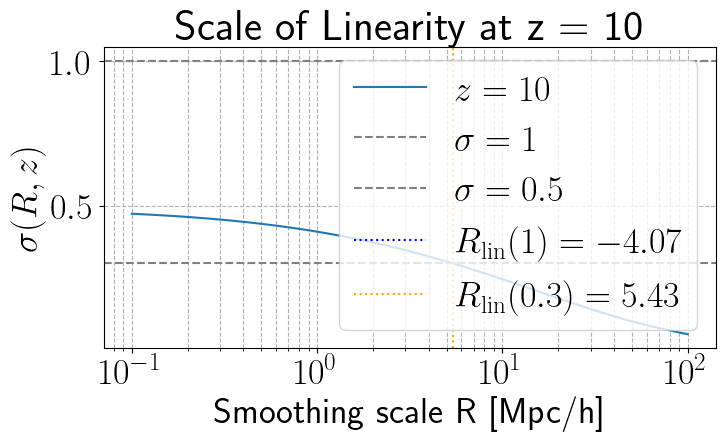

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.interpolate import interp1d
from colossus.cosmology import cosmology

# Set Planck18 cosmology
cosmo = cosmology.setCosmology('planck18')

# Define tophat window in Fourier space
def W(kR):
    return 3 * (np.sin(kR) - kR * np.cos(kR)) / kR**3

# Compute σ(R,z) from P(k)
def sigma_R(R, z):
    k = np.logspace(-3, 2, 1000)  # h/Mpc
    P = cosmo.matterPowerSpectrum(k, z)  # in (Mpc/h)^3
    kR = k * R
    integrand = k**2 * P * W(kR)**2
    return np.sqrt(simps(integrand, np.log(k)) / (2 * np.pi**2))

# Range of smoothing scales
R_vals = np.logspace(-1, 2, 100)  # Mpc/h
z = 10
sigma_vals = np.array([sigma_R(R, z) for R in R_vals])

# Interpolate for R_lin where σ = 1 or 0.5
interp = interp1d(sigma_vals, R_vals, bounds_error=False, fill_value="extrapolate")
R_lin_1 = interp(1.0)
R_lin_03 = interp(0.3)
k_lin_1 = 2 * np.pi / R_lin_1
k_lin_03 = 2 * np.pi / R_lin_03

print(f"At z = {z}:")
print(f"  R_lin (σ=1) ≈ {R_lin_1:.2f} Mpc/h → k ≈ {k_lin_1:.2f} h/Mpc")
print(f"  R_lin (σ=0.3) ≈ {R_lin_03:.2f} Mpc/h → k ≈ {k_lin_03:.2f} h/Mpc")
print(f"  R_lin (σ=0.1) ≈ {interp(0.1):.2f} Mpc/h")
print(f"  R_lin (σ=0.4) ≈ {interp(0.4):.2f} Mpc/h")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(R_vals, sigma_vals, label=f"$z = {z}$")
plt.axhline(1.0, color='gray', linestyle='--', label=r"$\sigma = 1$")
plt.axhline(0.3, color='gray', linestyle='--', label=r"$\sigma = 0.5$")
plt.axvline(R_lin_1, color='blue', linestyle=':', label=fr"$R_\mathrm{{lin}}(1) = {R_lin_1:.2f}$")
plt.axvline(R_lin_03, color='orange', linestyle=':', label=fr"$R_\mathrm{{lin}}(0.3) = {R_lin_03:.2f}$")
plt.xscale('log')
plt.xlabel("Smoothing scale R [Mpc/h]")
plt.ylabel(r"$\sigma(R, z)$")
plt.title(f"Scale of Linearity at z = {z}")
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
import cosmic_variance as cv

In [46]:
help(cv.cosmic_variance)

Help on module cosmic_variance.cosmic_variance in cosmic_variance:

NAME
    cosmic_variance.cosmic_variance

DESCRIPTION
    # Rewritten by Christian Kragh Jespersen, @astrockragh, to work in Python 3.8 (Jan-2023)
    # Dependencies are numpy, scipy, and pandas
    # If anyone (including future me) wants to optimize for speed, the bottleneck is the intpk4 integral

FUNCTIONS
    get_cv(side1, side2, zarr, name=None, dz=None, acc='low', OmegaM=0.308, OmegaL=0.692, OmegaBaryon=0.047858963983954186, sigma8=0.82, ns=0.96, h=0.678, verbose=False)
        Method to calculate the cosmic variance for a given survey area and redshift bins.
        Give side lengths in degrees
        side1: side length 1 [degrees]
        side2: side length 2 [degrees]
        zarr: array of redshift bin edges
        name: name of the output file. File will be saved at dfs/name.csv if name is not None
        dz: redshift bin size. If None, the redshift bin size will be the difference between the redshift bin

In [49]:
outs = cv.cosmic_variance.get_cv(12/60, 12/60, np.array( [9.2, 10.7] ), name = None)
outs

9.95 1.5 0.022759406282816114 0.7177691243069226 0.7177691243069226 0.7177691243069226 0.7177691243069226 0.8328939815662851 1.9112857036072357 1.9004506291426189 3.2778169617736745 4.005684765368412


,zmid,dz,cv_dm,cv_70,cv_75,cv_80,cv_85,cv_90,cv_95,cv_100,cv_105,cv_110
0,9.95,1.5,0.022759,0.717769,0.717769,0.717769,0.717769,0.832894,1.911286,1.900451,3.277817,4.005685
